In [1]:
from datasets import load_dataset

dataset = load_dataset("jo-mengr/cellxgene_pseudo_bulk_35k_pairs_cell_type_batch")

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import json

import anndata
import numpy as np
import requests

adata_ref = json.loads(dataset["train"]["anndata_ref"][0])
caption = dataset["train"]["caption"]  # For dataset_type "pairs"
# caption = dataset["train"]["positive"] #For dataset_type "multiplet"
adata_share_link = adata_ref["file_record"]["dataset_path"]
embedding_matrix_share_link = adata_ref["file_record"]["embeddings"][
    "X_scvi"
]  # directly access a seperatly stored embedding matrix
sample_id = adata_ref["sample_id"]
save_path = "data/adata.h5ad"
# read the whole adata
response = requests.get(adata_share_link)
if response.status_code == 200:
    # Write the content of the response to a local file
    with open(save_path, "wb") as file:
        file.write(response.content)
else:
    print("Failed to read data from share link.")
adata = anndata.read_h5ad(save_path)

save_path = "data/embedding.npy"
# The dataset contains several pre-computed embeddings. Lets for example get the embeddings computed with "scvi":
sample_idx = adata.obs.index == sample_id
sample_embedding = adata.obsm["X_scvi"][sample_idx]
# This sample embedding is described the the caption (loaded above)
# The same embedding should be obtainable from the embedding matrix directly
response = requests.get(embedding_matrix_share_link)
if response.status_code == 200:
    # Write the content of the response to a local file
    with open(save_path, "wb") as file:
        file.write(response.content)
else:
    print("Failed to read data from share link.")
# Load the .npz file
npzfile = np.load(save_path, allow_pickle=True)
# Extract arrays from the keys
emb_matrix = npzfile["data"]  # Assuming "data" contains your embeddings
sample_ids = npzfile["sample_ids"]  # Assuming "sample_ids" contains the corresponding sample IDs
sample_embedding_2 = emb_matrix[sample_ids == sample_id]
assert np.allclose(sample_embedding, sample_embedding_2)

FileNotFoundError: [Errno 2] No such file or directory: '../data/adata.h5ad'

In [5]:
from sentence_transformers import SentenceTransformer

text_model = SentenceTransformer("pritamdeka/S-BioBert-snli-multinli-stsb")
# build a list with 100 repetitions of the string "neuron"
cell_types = ["neuron"] * 100
# encode the list with the model
embeddings = text_model.encode(cell_types)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


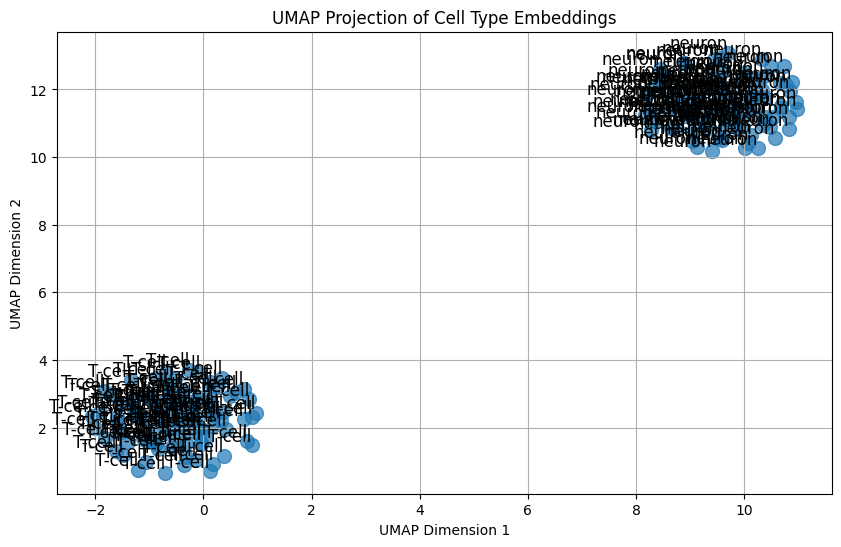

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define UMAP parameters and fit-transform the embeddings
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, metric="cosine", random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

# Plot UMAP visualization
plt.figure(figsize=(10, 6))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=100, alpha=0.7)

# Add labels
for i, label in enumerate(cell_types):
    plt.text(umap_embeddings[i, 0], umap_embeddings[i, 1], label, fontsize=12, ha="right", va="bottom")

plt.title("UMAP Projection of Cell Type Embeddings")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.grid(True)
plt.show()